# Landmark Detection with Aruco Markers
In this section we'll create a pose graph. We'll use optical flow estimates to construct odometry edges in our graph and detect arUco Markers as our landmark observations.
Code in this section has been adapted from https://pyimagesearch.com/2020/12/21/detecting-aruco-markers-with-opencv-and-python/


In [30]:
import argparse
import cv2
import sys
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.spatial.transform import Rotation

/home/yoraish/.local/lib/python3.8/site-packages/matplotlib/text.py:1242: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


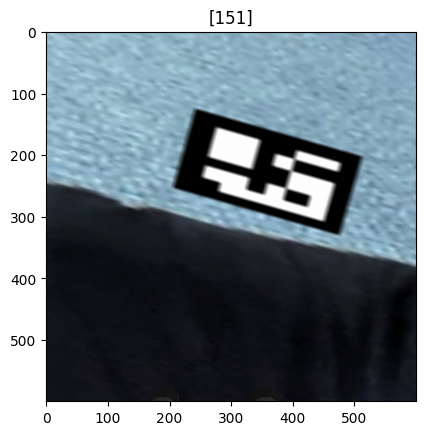

2.51313849433456 0.11238503764067365 2.51313849433456


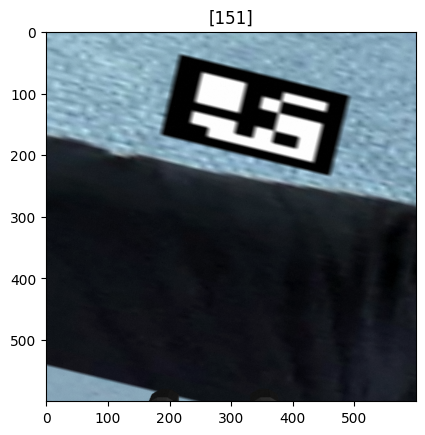

2.6356469029627254 -0.007140578988436008 2.6356469029627254


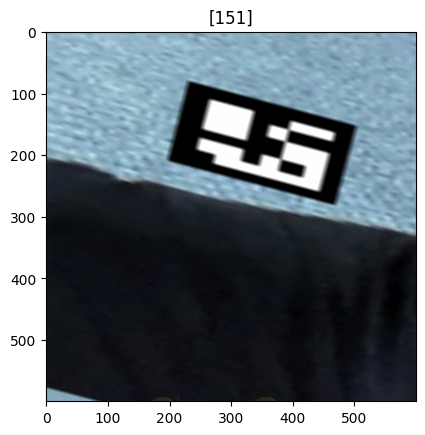

2.5837049349059815 0.04335031659632227 2.5837049349059815


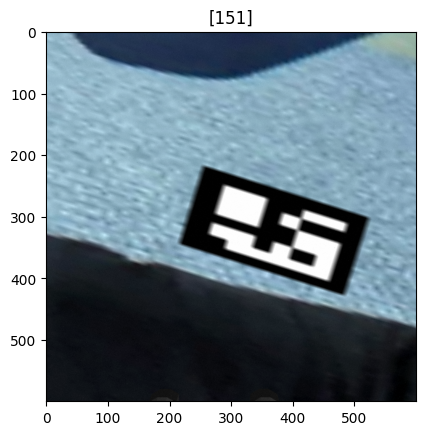

-2.276624814526418 0.314578635182724 -2.276624814526418


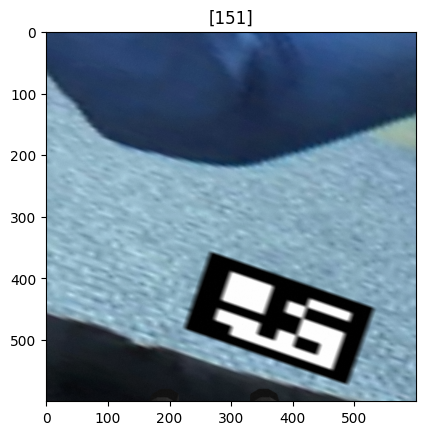

-2.59206426720098 0.31684696190756156 -2.59206426720098


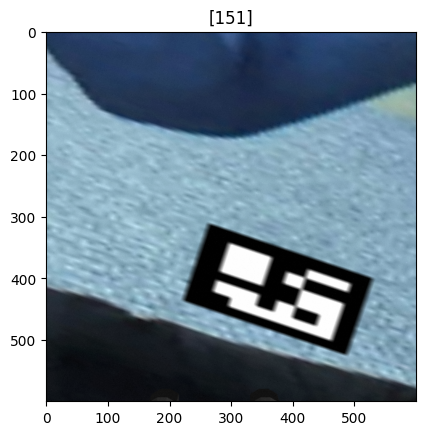

-2.5093452576169524 0.33214545973172815 -2.5093452576169524


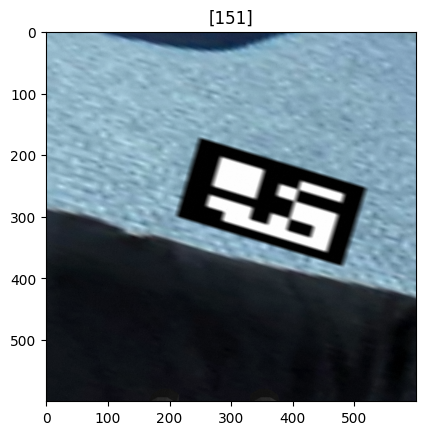

2.4118558206859206 0.20840483892446304 2.4118558206859206


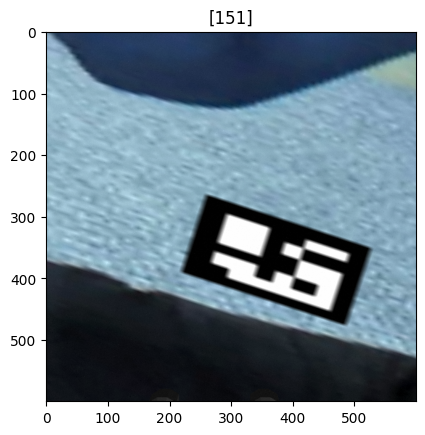

-2.4053684067897696 0.34046399511679515 -2.4053684067897696
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
   0.00000000e+00]
 [ 1.00000000e+00  2.00000000e+00  1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 0.00000000e+00  1.00000000e+00  1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 3.00000000e+00  4.00000000e+00  1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 6.00000000e+00  7.00000000e+00  1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 5.00000000e+00  6.00000000e+00  1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 2.00000000e+00  3.00000000e+00  1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 4.00000000e+00  5.00000000e+00  1.00000000e-01  0.00000000e+00
   0.00000000e+00]
 [ 2.00000000e+00  1.51000000e+05  3.94074865e-01 -2.50796638e-01
   1.12385038e-01]
 [ 0.00000000e+00  1.51000000e+05  7.35749714e-01 -1.72935655e-01
  -7.14057899e-03]
 [ 1.00000000e+00  1.51000000e+05  5.69907835e-01 -2.14661305e-01
   4.33503166e-02]
 [ 4.

In [34]:
# General arUco information.
arucoDict = cv2.aruco.Dictionary_get(cv2.aruco.DICT_6X6_1000)
arucoParams = cv2.aruco.DetectorParameters_create()

# General camera information.
camera_matrix = np.array([[299.99889804049286, 0.0, 300.5], 
                            [0.0, 299.99889804049286, 300.5],
                            [0.0, 0.0, 1.0]])
camera_matrix = cv2.getDefaultNewCameraMatrix(camera_matrix, (600, 600))
dist_coeffs = np.array([0,0,0,0,0])

# Get a sequence of images to process.
image_dir_gp = "../../media/tmp/"
img_fns = os.listdir(image_dir_gp)
img_gps = [os.path.join(image_dir_gp, img_fns[i]) for i in range(len(img_fns))]

# Set up a container for detected landmarks. Of the form (i, landmark_ix, dx, dy, dtheta). i is the step number.
landmarks = []
# Tentative guess for the trajectory. Set each motion to be 0.1 meters forward between frames.
# The first motion is an assignment of the first node.
traj = [[0,0,0,0,0]]

for img_gp in img_gps:
    i = int(img_gp.split("/")[-1].split(".")[0])

    if i > 0:
        traj.append([i-1, i, 0.1,0,0])
    # Load the image.
    img = cv2.imread(img_gp)

    # Find corners of arUco marker in the image.
    (detected_corners, ids, rejected) = cv2.aruco.detectMarkers(img, arucoDict,
        parameters=arucoParams)
        
    # If found any markers, estimate their pose w.r.t. the camera.
    if len(detected_corners) > 0:
        for marker_corners, marker_id in zip(detected_corners, ids):
            plt.imshow(img)
            plt.title(marker_id)
            plt.show()
            
            rvec, tvec, _ = cv2.aruco.estimatePoseSingleMarkers(marker_corners, 1., camera_matrix, dist_coeffs)
            # Convert the rotation vector to euler.
            roll, pitch, yaw = Rotation.from_rotvec(rvec.flatten()).as_euler('xyz')
            print(roll, pitch, roll)

            # Transform to the robot frame.
            tvec = tvec.flatten()
            x = -tvec[1]
            y = -tvec[0]
            theta = roll

            # Constrain theta to be between -pi and pi.
            if theta < -np.pi:
                theta += np.pi
            if theta > np.pi:
                theta -= 2 * np.pi

            landmarks.append([i, 1000*marker_id[0], x, y, theta])
            
# Save the information.
traj_and_observations = np.array(traj + landmarks)
print(traj_and_observations)
np.save("../../data/collected_traj.npy", traj_and_observations)
